# K-degree constrained MST
Dato un grafo non orientato e non completo, e dato un nodo $r$, si determini l’albero di copertura di radice $r$ che minimizza il numero di figli di ogni nodo -1 (dato un albero di copertura, orientato a partire dalla radice, ogni nodo i non foglia ha $k_i$ ≥ 1 figli. Si minimizza la somma su tutti i nodi i non foglia di $k_i-1$)

Obiettivo:
$$\text{min}\ \sum_{i\in V}{\ \text{max}((k_i - 1),0)}$$

In [1]:
import os
import networkx as nx
from random import seed, randint
import time

from shared import *
from generators import generate_graph
from search_algorithms import local_search

In [2]:
# PARAMETRI GENERALI
OUT_DIR = "out/ls" # dove salvare i disegni dei grafi (x debug)

ROOT_NODE = 7
MAX_NODES = 326
GRAPH_GENERATOR = "NOT_BEST_PATH" # [ NX_COMPLETE | NX_DENSE | NX_RANDOM | DENSE | SPARSE | NOT_BEST_PATH ]
RANDOM_SEED = 191295

### Inizializzazione

In [3]:
# CREAZIONE GRAFO e strutture
G = generate_graph(GRAPH_GENERATOR=GRAPH_GENERATOR, MAX_NODES=MAX_NODES, seed=RANDOM_SEED)


# Prepara directory in cui salvare i rendering
OUT_DIR = os.path.join(os.getcwd(),OUT_DIR)
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

[INFO] Uso generatore di grafi a stella NOT_BEST_PATH
[INFO] Aggiunte  33  stelle al grafo di partenza.


# Local Search
Una semplice ricerca locale che usa la soluzione greedy come punto di partenza :) 

In [4]:
# PARAMETRI RICERCA
MAX_ITER = 36000            # arresta la ricerca dopo queste iterazioni 
                            # (es. se il grafo è troppo grosso)

# [Debug]
DEBUG_IMPROVEMENT = False
SAVE_STEP_GRAPHS = False    

### 1. Creazione soluzione iniziale
Un'inizializzazione Greedy specifica per il problema dà un punto di partenza migliore di quello che si otterrebbe con MST-Kruskal nella maggior parte dei casi testati

In [5]:
# Creazione di MST con radice specificata tramite visita in ampiezza
def build_rooted_mst(graph, root_node):
    visited_nodes = set() # per evitare cicli
    next_visit = []

    MST = nx.Graph()

    #MST.add_node(n1) # non necessario, aggiunti in automatico con gli archi

    #next_visit = list(G.adj[root_node]) # inserisci i vicini del nodo di partenza

    next_visit.insert(0,root_node) # assicurati di partire dal nodo radice!
    #for n in next_visit:
    while len(next_visit) > 0:
        n = next_visit.pop(0)
        # processa un nodo solo se non è già stato visitato
        if n not in visited_nodes:
            visited_nodes.add(n)
            # aggiungi i suoi vicini non visitati alla lista/stack di visita
            unvisited_neighbourhood = [x for x in list(G.adj[n]) if x not in visited_nodes]
            #print("n = ",n)
            #print("unvisited_neighbourhood = ",unvisited_neighbourhood)
            #print("(before loop) next_visit = ",next_visit)
            # inserimento in testa -> depth first?
            next_visit = unvisited_neighbourhood + next_visit
            for neighbour in unvisited_neighbourhood:
                if neighbour not in MST.nodes:
                    #print("MST edge added: ", (n,neighbour))
                    MST.add_edge(n,neighbour)
            #print("(after loop) next_visit = ",next_visit) 
        #else:
            #print("n = ", n, "(ignored)")

    return MST

In [6]:
# Creazione di MST con radice specificata tramite visita in profondità

def build_depth_first_mst(graph, node):
    MST = nx.Graph()
    return recursive_depth_first(graph, node, MST)

def recursive_depth_first(graph, node, MST):
    # MST è una risorsa condivisa tra le ricorsioni
    # TODO: trovare un modo più elegante di aggiornarlo
    children = graph.adj[node]
    for child in children:
        if child not in MST.nodes:
            MST.add_edge(node, child)
            MST = recursive_depth_first(graph, child, MST)

    return MST

In [7]:
# Creazione soluzione iniziale
#mst = build_rooted_mst(G, ROOT_NODE)
mst = build_depth_first_mst(G, ROOT_NODE)
#mst = nx.algorithms.minimum_spanning_tree(G, algorithm="kruskal")

In [8]:
# PRINT INFO SOL. INIZIALE
print("Costo iniziale:", cost(mst, ROOT_NODE))
print("MST = ", mst.edges)

print("")
print("---DETTAGLI---")
V = G.number_of_nodes()
E = G.number_of_edges()
print("Generatore: ",GRAPH_GENERATOR)
print("|V| = ", V)
print("|E| = ", E)



print("")
print("---TEST AMMISSIBILITA'---")

print("grafo è non completo: ", not (E == V*(V-1)/2))

Costo iniziale: 163
MST =  [(7, 0), (0, 1), (1, 8), (8, 2), (2, 10), (10, 4), (10, 268), (4, 9), (4, 168), (9, 5), (9, 208), (9, 273), (5, 19), (19, 17), (17, 12), (17, 218), (12, 3), (3, 11), (11, 13), (13, 15), (15, 14), (14, 21), (21, 25), (25, 26), (26, 22), (22, 18), (18, 28), (28, 80), (80, 83), (80, 178), (83, 44), (44, 33), (44, 188), (44, 313), (33, 20), (20, 32), (32, 23), (23, 16), (16, 34), (34, 51), (51, 46), (46, 29), (29, 40), (29, 114), (29, 152), (40, 48), (40, 233), (40, 308), (48, 41), (41, 35), (41, 258), (35, 36), (35, 91), (36, 63), (63, 39), (39, 24), (24, 27), (27, 6), (6, 79), (6, 238), (79, 56), (56, 37), (37, 45), (45, 30), (30, 58), (58, 50), (50, 31), (31, 38), (31, 66), (31, 86), (38, 43), (43, 53), (53, 64), (53, 183), (53, 203), (53, 288), (64, 95), (95, 59), (95, 104), (59, 73), (59, 138), (59, 263), (73, 121), (121, 115), (115, 67), (67, 60), (60, 57), (57, 75), (75, 68), (68, 78), (68, 155), (78, 76), (78, 142), (76, 88), (88, 65), (88, 133), (88, 243

### 2. Improvement

In [9]:
# LOCAL SEARCH
start_time = time.time()
results = local_search(G, start_solution=mst, ROOT_NODE=ROOT_NODE, MAX_ITER=MAX_ITER)
end_time = time.time()

mst = results["solution"]
iter = results["elapsed_iterations"]
iters_since_last_improvement = results["since_last_improvement_iterations"]

In [10]:
# PRINT RESULTS
print("Costo finale: ", cost(mst, ROOT_NODE))
print("MST = ",mst.edges)

print("")
print("---DETTAGLI---")
print("Iterazioni complessive eseguite: {}/{}".format(iter,MAX_ITER))
print("Nodi non ottimali (nodo: n. figli): ",[{n: x-(ROOT_NODE!=n)*1} for (n,x) in mst.degree() if x > 2])
V = G.number_of_nodes()
E = G.number_of_edges()
print("Generatore: ",GRAPH_GENERATOR)
print("|V| = ", V)
print("|E| = ", E)



print("")
print("---TEST AMMISSIBILITA'---")

print("grafo è non completo: ", not (E == V*(V-1)/2))

print("soluzione è un albero: ",nx.is_tree(mst))

try:
    cycletest = nx.algorithms.cycles.find_cycle(mst, orientation="ignore")
except:
    cycletest = None
finally:
    print("cicli in soluzione: ", cycletest)


Costo finale:  139
MST =  [(7, 61), (7, 108), (0, 74), (0, 86), (0, 111), (0, 129), (0, 130), (0, 142), (1, 8), (1, 122), (8, 52), (2, 10), (2, 69), (10, 268), (4, 168), (4, 93), (4, 103), (9, 208), (9, 273), (9, 105), (5, 71), (5, 100), (19, 17), (19, 144), (17, 218), (12, 3), (12, 117), (3, 11), (11, 13), (13, 15), (15, 14), (14, 21), (21, 25), (25, 26), (26, 22), (22, 18), (18, 28), (28, 80), (80, 178), (83, 44), (83, 91), (44, 188), (44, 313), (33, 20), (33, 98), (20, 32), (32, 23), (23, 16), (16, 34), (34, 51), (51, 46), (46, 29), (29, 114), (29, 152), (40, 48), (40, 233), (40, 308), (48, 41), (41, 258), (41, 66), (35, 36), (35, 91), (36, 63), (63, 39), (39, 24), (24, 27), (27, 6), (6, 79), (6, 238), (79, 56), (56, 37), (37, 45), (45, 30), (30, 58), (58, 50), (50, 31), (31, 38), (31, 66), (31, 86), (38, 43), (43, 53), (53, 64), (53, 183), (53, 203), (53, 288), (64, 95), (95, 104), (59, 73), (59, 138), (59, 263), (73, 121), (121, 115), (115, 67), (67, 60), (60, 57), (57, 75), (57, 

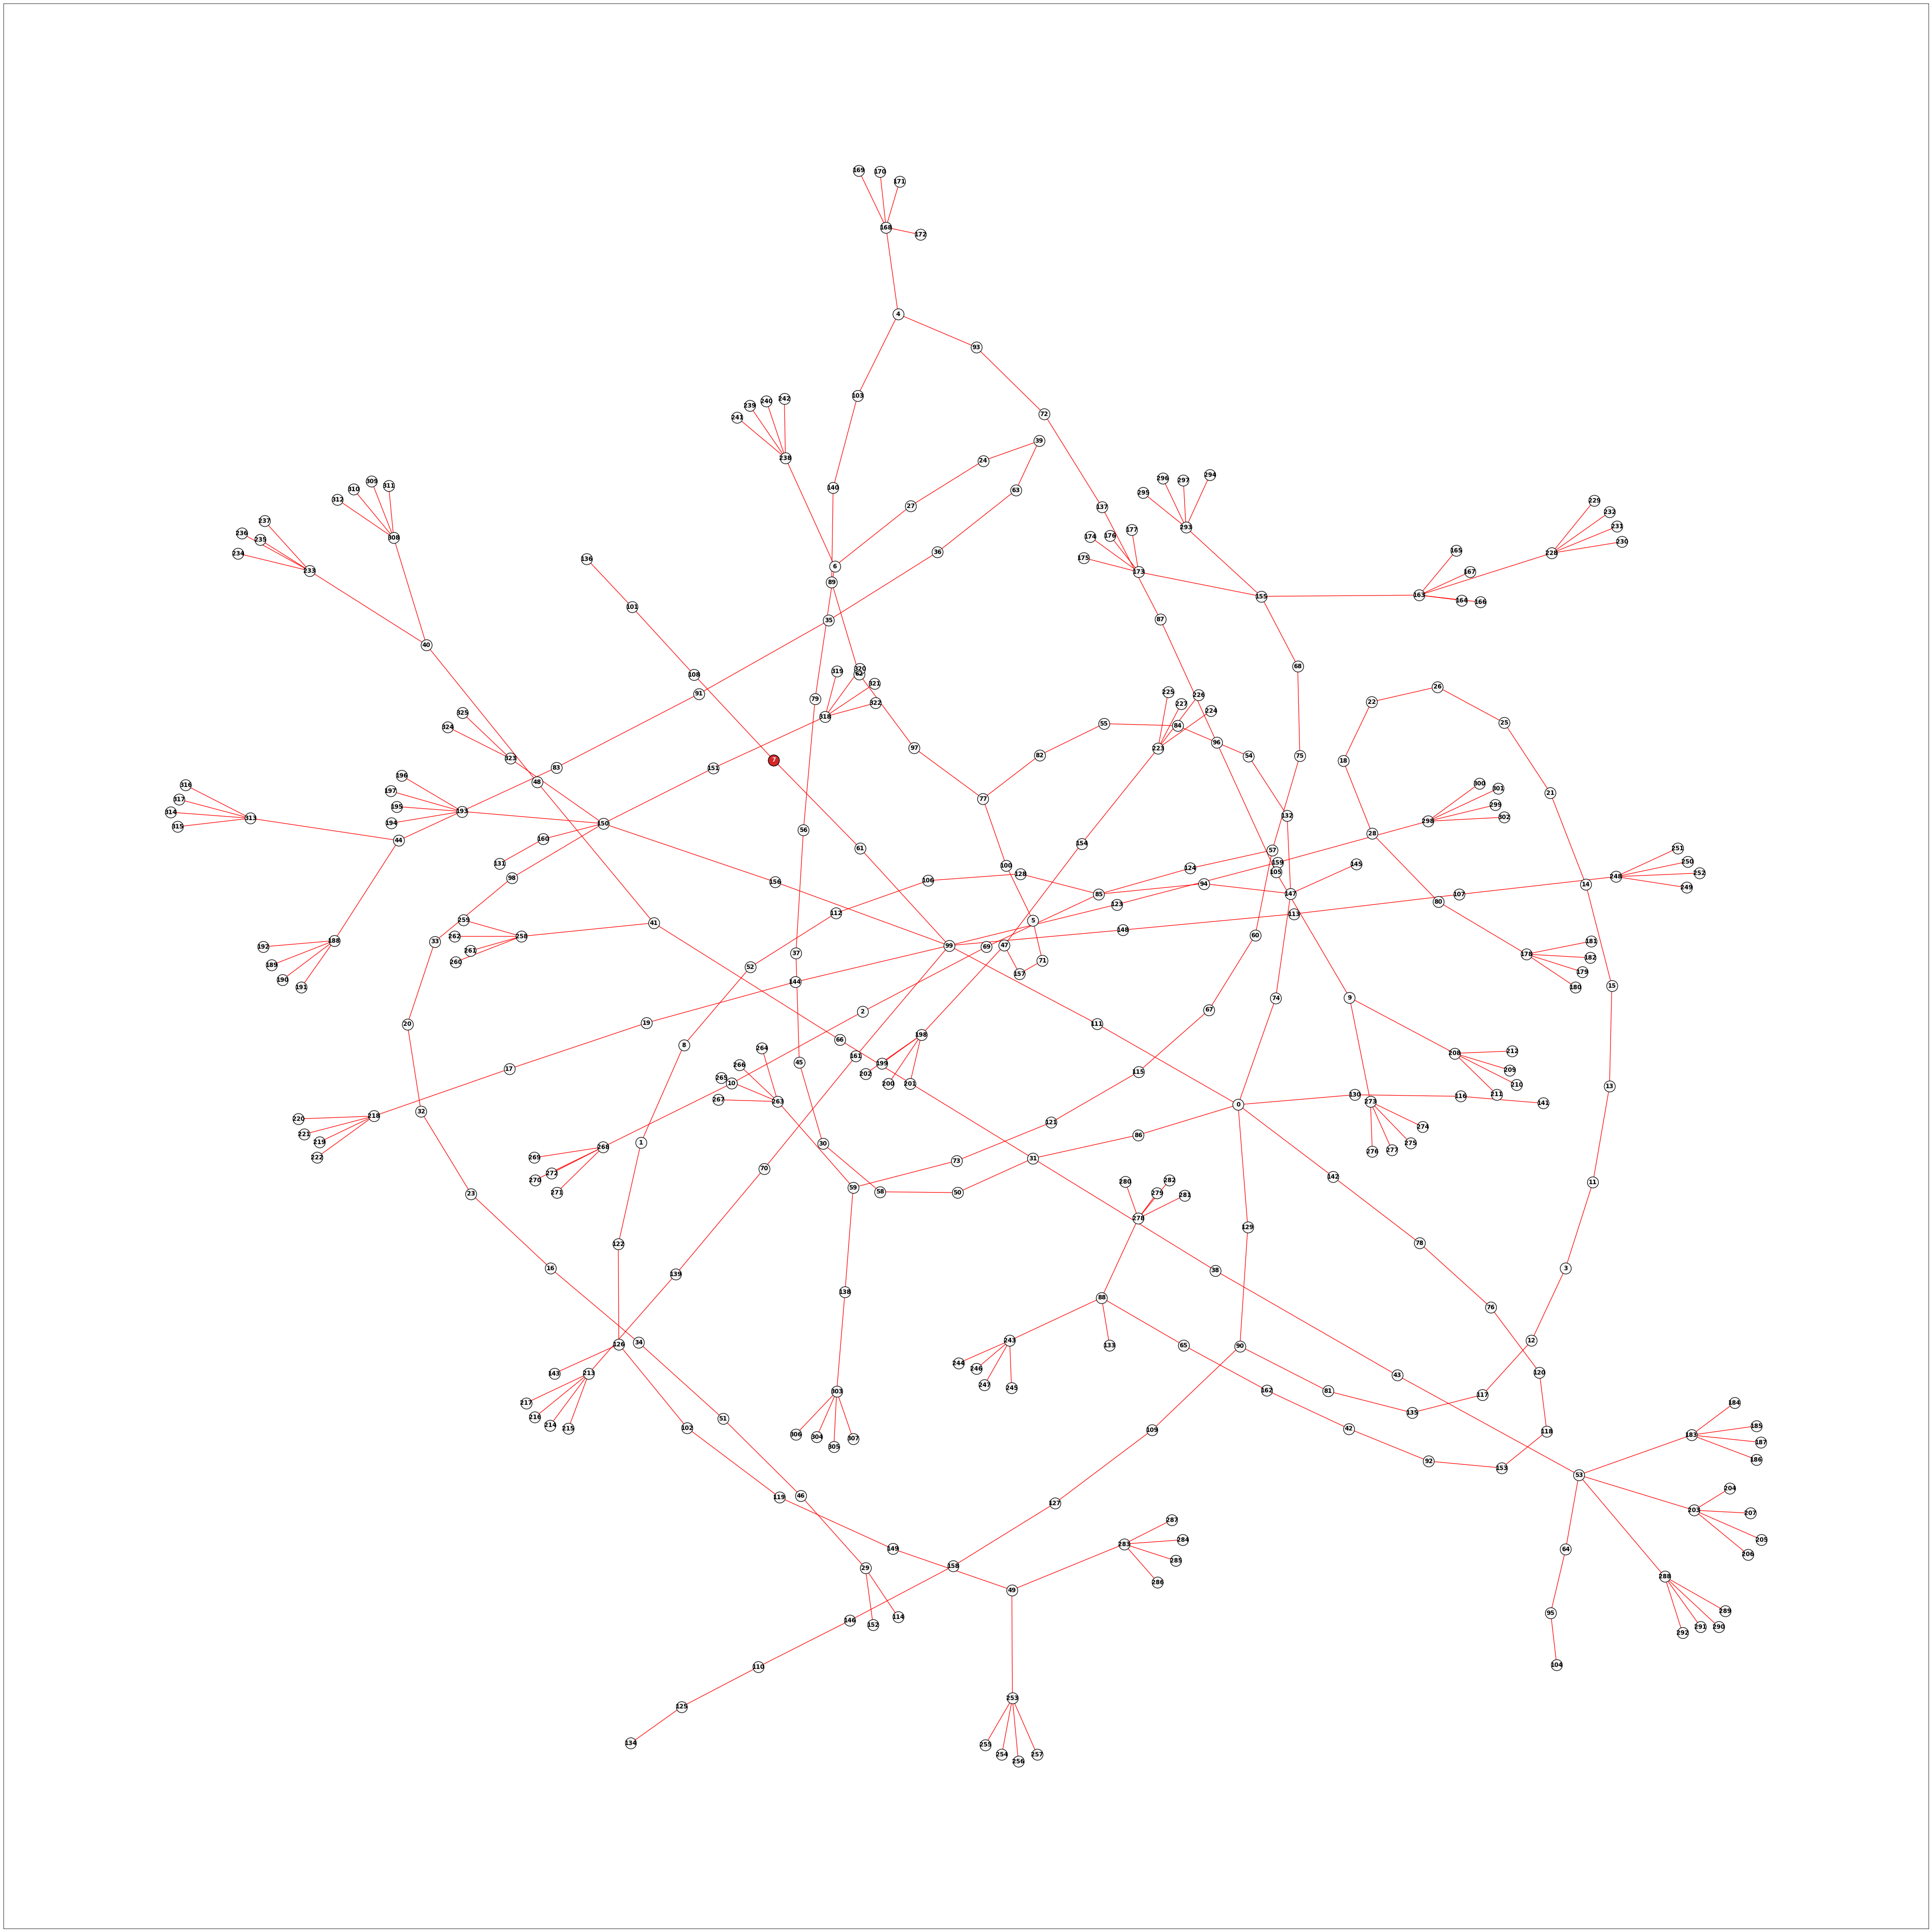

In [11]:
# RENDERING MST
draw_graph(mst, mst, ROOT_NODE)
save_figure(name="mst_final")

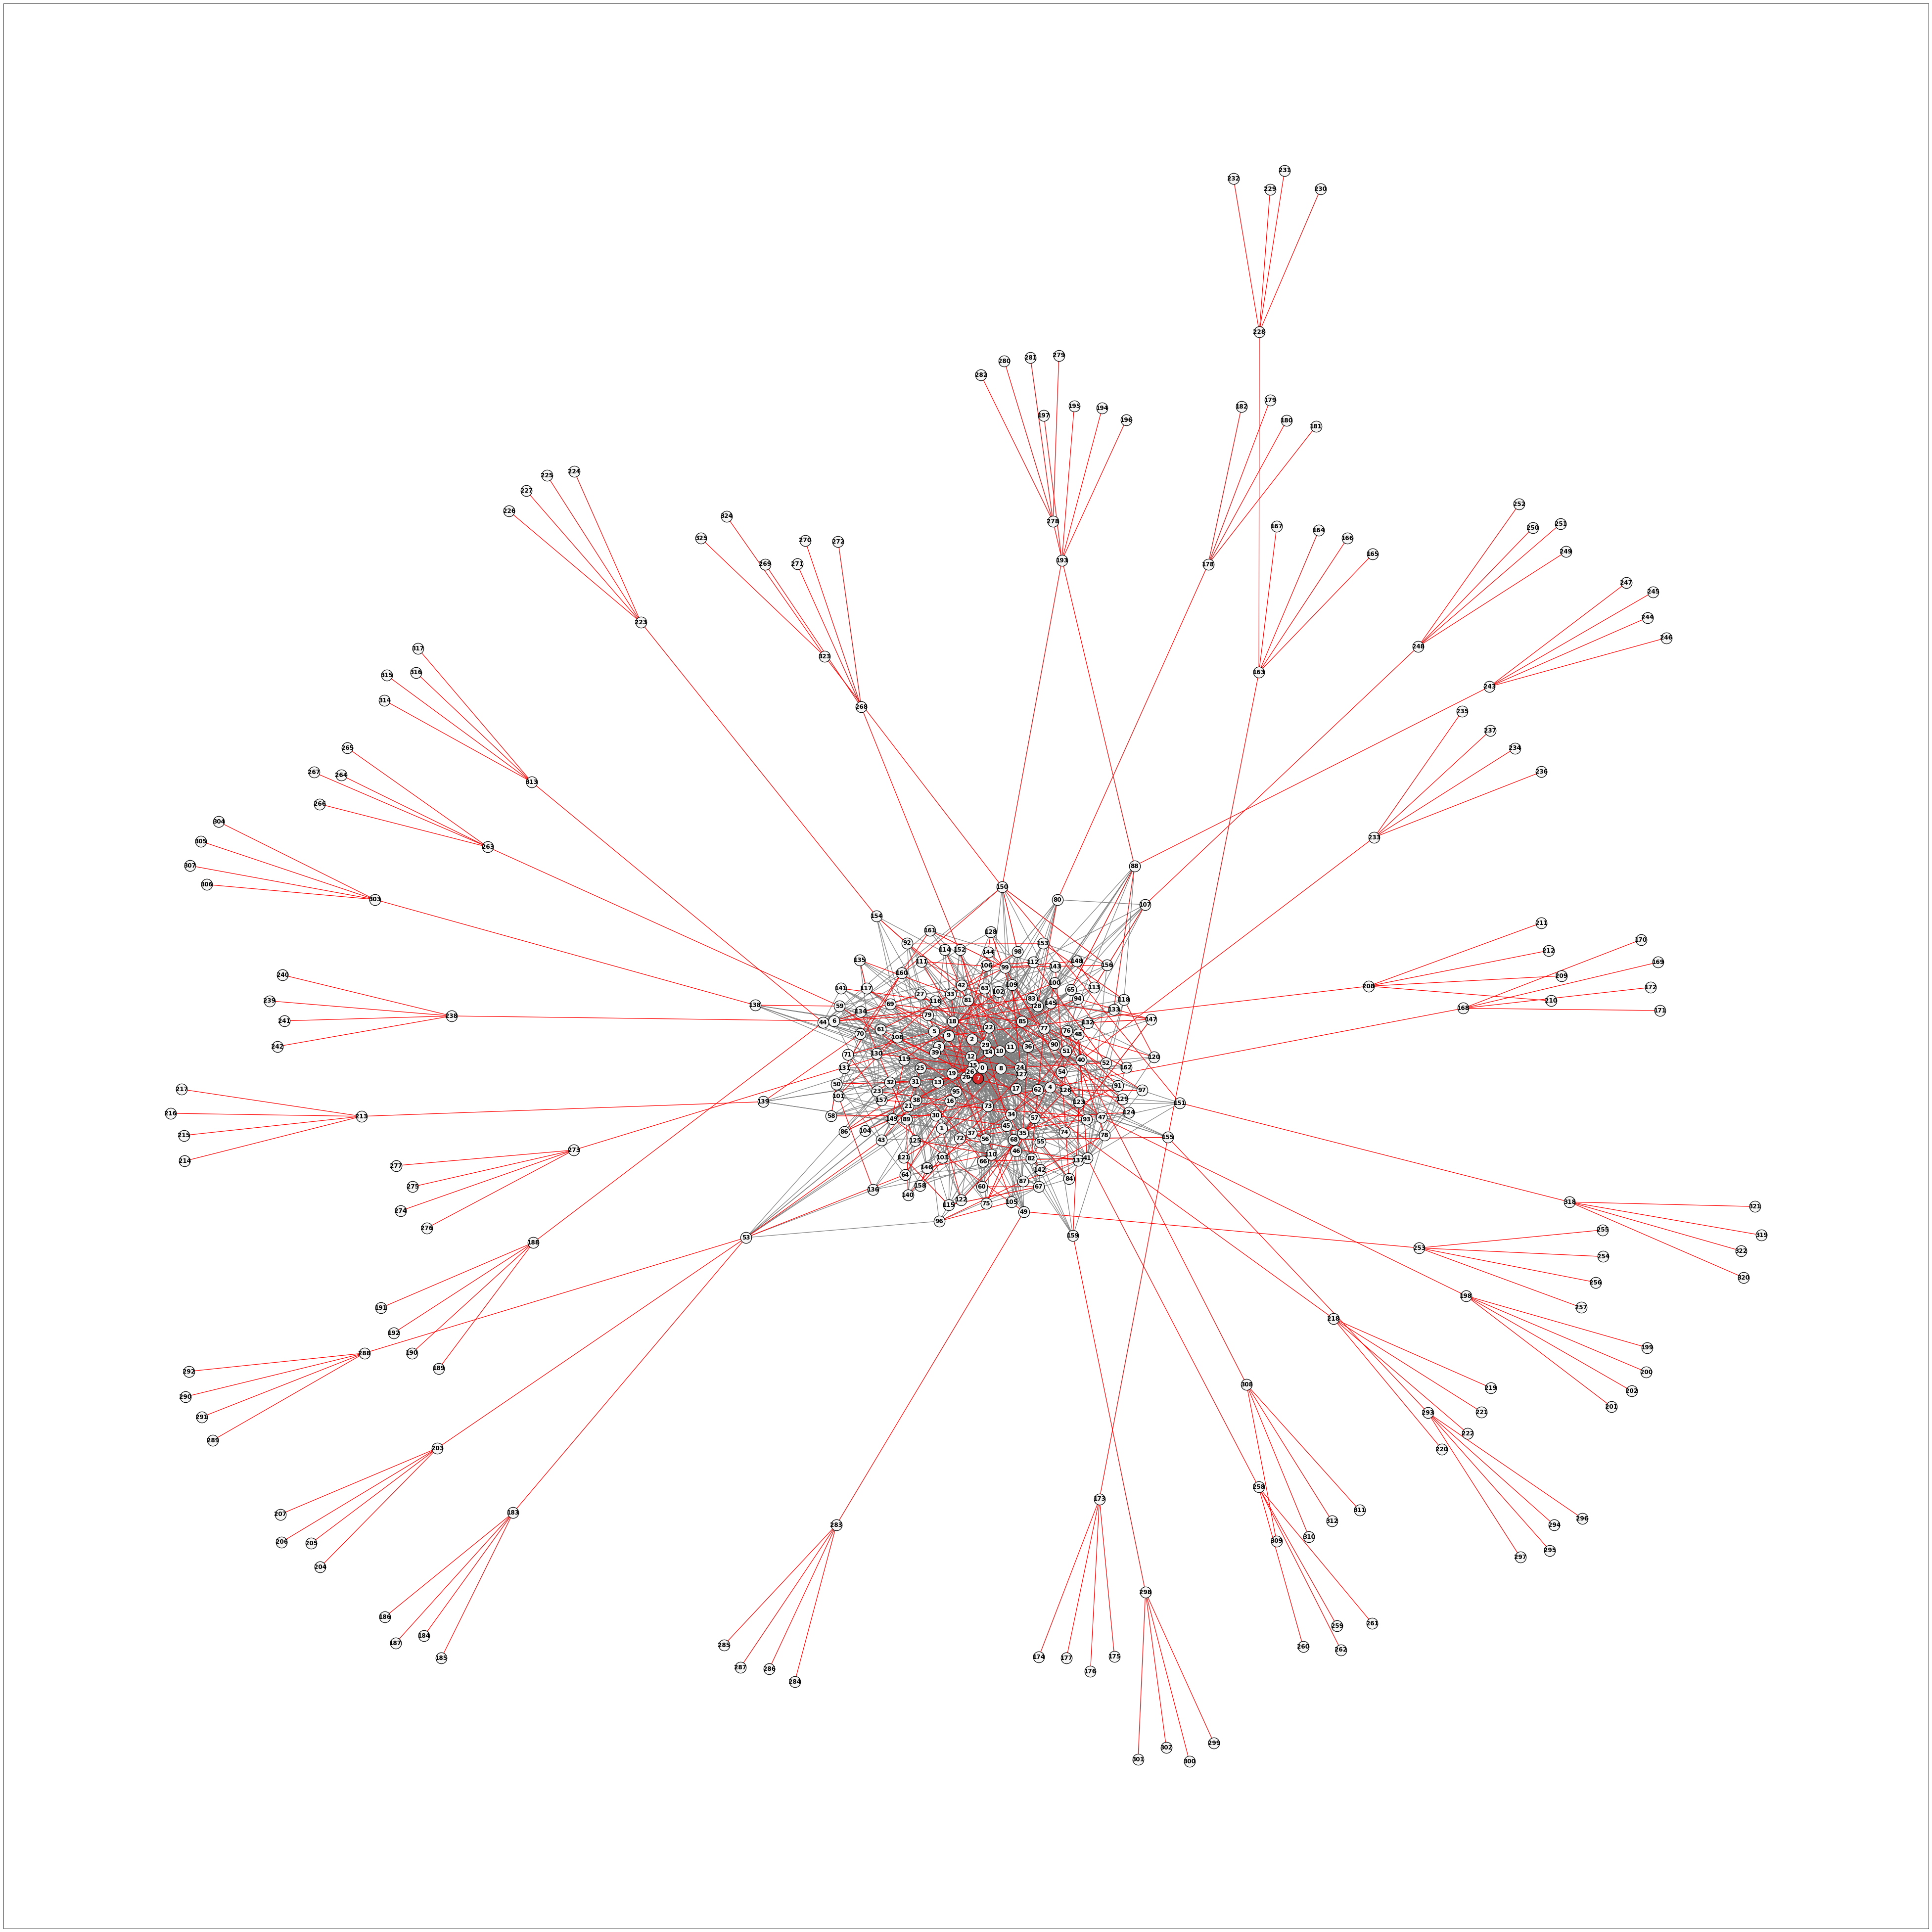

In [12]:
# RENDERING MST SOPRA AL GRAFO
draw_graph(G, mst, ROOT_NODE)
save_figure(name="final")

In [13]:
# Notifica completamento
from plyer import notification

notification_message = """
Found a solution with cost {}
Elapsed time: {:.2f}s
Iterations completed: {}/{}

""".format(
        cost(mst, ROOT_NODE),
        (end_time-start_time),
        iter, MAX_ITER,OUT_DIR
    )

notification.notify(
    title="MST computation finished (LS)",
    message=notification_message,
    app_name="ProgettoRO",
    #app_icon="python.exe",
    timeout=15
)